# Intializing Scope and Target

In [1]:
import chipwhisperer as cw

In [2]:
scope=cw.scope()

In [3]:
target_type= cw.targets.SimpleSerial

In [4]:
target=cw.target(scope,target_type)

In [5]:
prog = cw.programmers.STM32FProgrammer

In [6]:
import time
time.sleep(0.05)
scope.default_setup()
scope.io.nrst = 'low'
time.sleep(0.05)
scope.io.nrst = 'high_z'
time.sleep(0.05)

In [7]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

# Making the Necessary files for dump

In [8]:
%%sh 
cd "C:/Users/ankid/ChipWhisperer5_64/cw/home/portable/chipwhisperer/hardware/victims/firmware/simpleserial-aes"
make PLATFORM=CWNANO CRYPTO_TARGET=TINYAES128C

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
    simpleserial-aes.c ...Done!
.
Compiling:
    .././simpleserial/simpleserial.c ...Done!
.
Compiling:
    .././hal/stm32f0_nano/stm32f0_hal_nano.c 

# Dumping Crypto on Target

In [9]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "C:/Users/ankid/ChipWhisperer5_64/cw/home/portable/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-CWNANO.hex")

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5971 bytes


# Writing the key

In [24]:
key = bytearray.fromhex('20 12 32 59 64 36 10 20 38 11 27 54 13 65 24 33')
target.simpleserial_write('k', key)
time.sleep(0.1)

# Collecting trace for fixed plain texts

In [11]:
from tqdm.notebook import trange
import numpy as np
import time


pt = bytearray.fromhex('00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00')


#target.simpleserial_write('p', pt)
time.sleep(0.1)

fixed_trace_array = []
fixed_textin_array = []
fixed_textout_array = []

#key, text = ktp.next()

#target.set_key(key)

N = 1000
for i in range(N):
    target.flush()
    scope.arm()
    
    target.simpleserial_write('p', pt)
    
    ret = scope.capture()  # Increase timeout duration

    #ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)

    fixed_textout_array.append(response)
    
    fixed_trace_array.append(scope.get_last_trace())
    fixed_textin_array.append(pt)
    
    #key, text = ktp.next() 

# Collecting Trace for Random Plain text

In [12]:


time.sleep(0.1)

random_trace_array = []
random_textin_array = []
random_textout_array = []

N = 1000
pt=[bytearray([(i+j)%256 for j in range(16)]) for i in range(N)]


for i in pt:
    target.flush()
    scope.arm()
    
    target.simpleserial_write('p', i)
    
    ret = scope.capture()  # Increase timeout duration

    #ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)

    random_textout_array.append(response)
    
    random_trace_array.append(scope.get_last_trace())
    random_textin_array.append(i)

# Converting them to Suitable form

In [15]:
fixed_trace= np.array(fixed_trace_array)

In [16]:
random_trace= np.array(random_trace_array)

# Performing TVLA

[  2.59450578  11.57021288   3.83552322 ... -27.29254292 -14.15061487
  15.05134085]
The maximum value is ->  85.74463320710757
The potential Lekage detected !!! 85.74463320710757


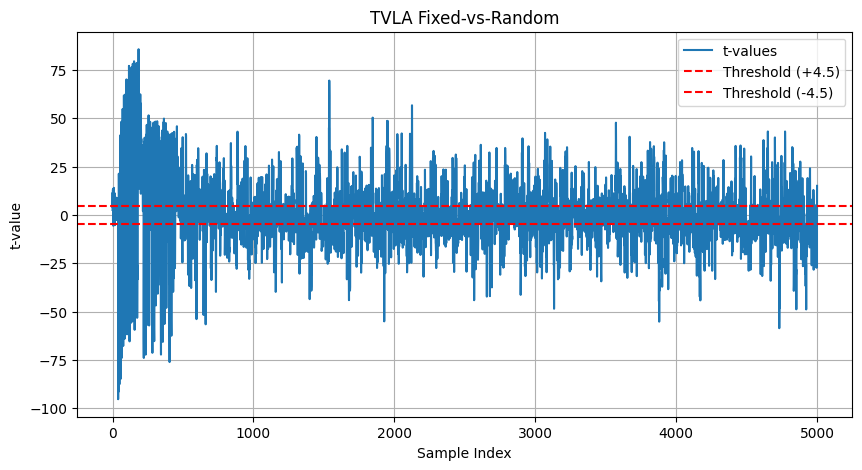

In [22]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

def calculate_tvla(trace_set1, trace_set2):
    """
    Calculate TVLA between two sets of power traces.
    
    Parameters:
        trace_set1 (np.ndarray): First set of power traces.
        trace_set2 (np.ndarray): Second set of power traces.
    
    Returns:
        np.ndarray: TVLA values.
    """
    # Calculate mean and standard deviation of both sets
    mean1 = np.mean(trace_set1, axis=0)
    mean2 = np.mean(trace_set2, axis=0)
    std1 = np.std(trace_set1, axis=0, ddof=1)
    std2 = np.std(trace_set2, axis=0, ddof=1)
    
    # Number of traces in each set
    n1 = trace_set1.shape[0]
    n2 = trace_set2.shape[0]
    
    # Calculate T-test values
    t_values = (mean1 - mean2) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    return t_values

# Example usage with power traces
# Assuming power_traces1 and power_traces2 are numpy arrays with dimensions (num_traces, trace_length)
# power_traces1 = fixed
# power_traces2 = random

# Calculate TVLA
tvla_values = calculate_tvla(fixed_trace, random_trace)

# Print TVLA values
print(tvla_values)
#print(tvla_values.shape)
max_value= max(tvla_values)
print('The maximum value is -> ',max_value)

if max_value> 4.5:
    print('The potential Lekage detected !!!', max_value)
else:
    print('There is no potential Lekage that is detected')


 # Plot results

plt.figure(figsize=(10, 5))
plt.plot(tvla_values, label="t-values")
plt.axhline(4.5, color="r", linestyle="--", label="Threshold (+4.5)")
plt.axhline(-4.5, color="r", linestyle="--", label="Threshold (-4.5)")
plt.title("TVLA Fixed-vs-Random")
plt.xlabel("Sample Index")
plt.ylabel("t-value")
plt.legend()
plt.grid()
plt.show()


# Disconnect from chipwhisperer

In [25]:
scope.dis()
target.dis()